In [1]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
os.environ["TF_USE_NVLINK_FOR_PARALLEL_COMPILATION"] = "0"
p = os.environ["PATH"]
os.environ["PATH"] = f"{p}:/usr/local/cuda/bin"

from functools import partial
import jax
import jax.numpy as jnp
from jaxtyping import PyTree
from torch.utils.data import DataLoader
import equinox as eqx
import matplotlib.pyplot as plt
import distrax as dsx
import optax
import seaborn as sns

import tensorflow_datasets as tfds
from typing import Iterator, Mapping, NamedTuple, Sequence, Tuple
import numpy as np
from jax import jit

sns.set()

from model.image_vae import ImageVAE, ImageVAEOutput
from model.loss import ELBOLossOutput, get_evidence_lower_bound
from model.visualization import visualize_reconstructions

2024-02-03 20:35:43.200668: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-03 20:35:43.200699: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-03 20:35:43.201785: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-03 20:35:43.935556: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%load_ext autoreload
%autoreload 2

%cd /home/zyuanjue/repos/active-learning/mnistvae

/home/zyuanjue/repos/active-learning/mnistvae


In [3]:
BATCH_SIZE= 20
random_seed = 42
batch_size = BATCH_SIZE

In [4]:
import torch
from pdebench.models.fno.utils import FNODatasetSingle

filename = "2D/DarcyFlow/2D_DarcyFlow_beta0.01_Train.hdf5"
train_data = FNODatasetSingle(filename)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

.HDF5 file extension is assumed hereafter


plot saved


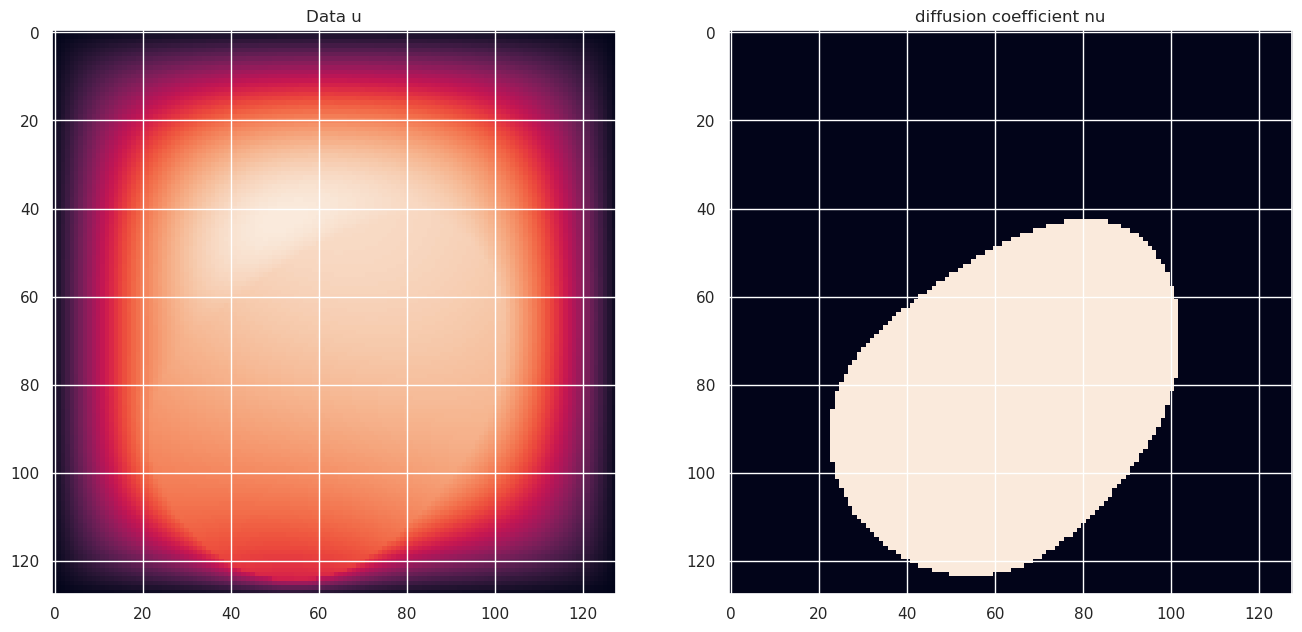

In [5]:
from model.darcy_visualization import visualize_darcy
path = "../data/2D/DarcyFlow"
visualize_darcy(path)

In [6]:
from model.encoder import ImageEncoder

key = jax.random.PRNGKey(0)
encoder = ImageEncoder(in_channels=2, out_channels=2, key=key)
encoder_fn = jax.vmap(encoder)

In [7]:
#test....
for batch in train_loader:
    inputs, data_, __ = batch  # Assuming batch is a tuple (inputs, labels)
    inputs = jnp.array(inputs)
    inputs = jnp.squeeze(inputs)
    print(inputs.shape)
    inputs = inputs.transpose((0, 3, 1, 2))
    x = encoder_fn(inputs)
    print (x.shape)
    break

(20, 128, 128, 2)
(20, 2)


In [8]:
from model.decoder import ImageDecoder

decoder = ImageDecoder(in_channels=2, out_channels=2, key=key)
decoder_fn = jax.vmap(decoder)
decoder_output = decoder_fn(x)


In [9]:
model_key, key = jax.random.split(key)
model = ImageVAE(in_channels=2, n_latents=2, key=model_key)
model_fn = jax.vmap(model)
keys = jax.random.split(key, BATCH_SIZE)
model_output: ImageVAEOutput = model_fn(inputs, key=keys)

In [10]:
loss_fn = jax.vmap(get_evidence_lower_bound)
loss_fn(inputs, model_output)

{'distortion': Array([0.88102025, 0.51801294, 0.6369133 , 0.8924219 , 0.8315798 ,
        0.5309797 , 0.7947638 , 0.9928509 , 0.6477486 , 0.7312894 ,
        0.70816636, 0.92823446, 0.77057326, 0.80039144, 0.7621943 ,
        0.6524497 , 0.7679057 , 0.6981537 , 0.90399694, 0.73352605],      dtype=float32),
 'loss': Array([0.8810272 , 0.5180199 , 0.6369203 , 0.8924288 , 0.8315867 ,
        0.53098667, 0.7947708 , 0.9928579 , 0.64775556, 0.73129636,
        0.70817333, 0.92824143, 0.77058023, 0.8003984 , 0.76220125,
        0.6524567 , 0.7679127 , 0.69816065, 0.9040039 , 0.733533  ],      dtype=float32),
 'rate': Array([6.9617308e-06, 6.9620646e-06, 6.9603766e-06, 6.9377475e-06,
        6.9433727e-06, 6.9621383e-06, 6.9602074e-06, 6.9507014e-06,
        6.9622220e-06, 6.9449334e-06, 6.9570578e-06, 6.9515318e-06,
        6.9768166e-06, 6.9528296e-06, 6.9673106e-06, 6.9640691e-06,
        6.9550970e-06, 6.9484331e-06, 6.9448097e-06, 6.9587759e-06],      dtype=float32)}

training!

In [12]:
key = jax.random.PRNGKey(0)

model_key, key = jax.random.split(key)
model = ImageVAE(in_channels=2, n_latents=2, key=model_key)

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

pad_fn = jax.vmap(partial(jnp.pad, pad_width=2))


@eqx.filter_value_and_grad(has_aux=True)
def grad_and_loss(model: eqx.Module, batch: jnp.array, key: jax.random.PRNGKey):
    
    model_fn = jax.vmap(model)
    loss_fn = jax.vmap(get_evidence_lower_bound)
    keys = jax.random.split(key, BATCH_SIZE)
    model_output: ImageVAEOutput = model_fn(batch, key=keys)
    loss_output: ELBOLossOutput = loss_fn(batch, model_output)
    return jnp.mean(loss_output["loss"]), jax.tree_map(jnp.mean, loss_output)



@eqx.filter_jit
def make_step(
    model: eqx.Module,
    opt_state: PyTree,
    batch: jnp.array,
    *,
    key: jax.random.PRNGKey,
):
    (loss, aux), grads = grad_and_loss(model, batch, key)
   
    updates, update_opt_state = optimizer.update(grads, opt_state)
    update_model = eqx.apply_updates(model, updates)
    return (loss, aux), update_model, update_opt_state

MAX_EPOCHS = 10
steps_per_epoch = 60000 // batch_size 

step = 0  
train_metrics = None

for epoch in range(MAX_EPOCHS):
    for batch in train_loader:

        inputs, data_, __ = batch  
        inputs = jnp.array(inputs)
        inputs = jnp.squeeze(inputs)
        inputs = inputs.transpose((0, 3, 1, 2))
        #targets = pad_fn(inputs)
        targets = inputs
        key, binarized_key = jax.random.split(key)
        targets = (
            dsx.Bernoulli(probs=targets).sample(seed=binarized_key).astype(jnp.float32)
        )

        key, step_key = jax.random.split(key)
        (loss, aux), model, opt_state = make_step(
            model, opt_state, targets, key=step_key
        )

        step += 1
        if step % 500 == 0:
            if train_metrics is None:
                train_metrics = {k: jnp.array([v]) for k, v in aux.items()}
                train_metrics["step"] = jnp.array([step])
            else:
                for k, v in aux.items():
                    train_metrics[k] = jnp.concatenate(
                        [train_metrics[k], jnp.array([v])]
                    )
                train_metrics["step"] = jnp.concatenate(
                    [train_metrics["step"], jnp.array([step])]
                )

            log_str = f"step/epoch: {step}/{epoch}"
            for k, v in aux.items():
                log_str += f"\t {k}: {v:.3f}"
            print(log_str)

        # Check if the epoch is completed
        # if step % steps_per_epoch == 0:
        #     break  # End the current epoch

# Reset step for the next epoch or other post-epoch processing


visualize_reconstructions(model, targets)

K = len(train_metrics) - 1
plt.figure(figsize=(4 * K, 4))
for i, (k, v) in enumerate(train_metrics.items()):
    if k == "step":
        continue
    plt.subplot(1, K, i + 1)
    plt.title(k)
    plt.plot(train_metrics["step"], v)
    plt.xlabel("Optimization step")

step/epoch: 500/1	 distortion: -0.400	 loss: -0.400	 rate: 0.000
step/epoch: 1000/2	 distortion: -0.923	 loss: -0.923	 rate: 0.000
step/epoch: 1500/3	 distortion: -0.691	 loss: -0.691	 rate: 0.000
step/epoch: 2000/4	 distortion: -0.713	 loss: -0.712	 rate: 0.000
step/epoch: 2500/5	 distortion: -0.940	 loss: -0.940	 rate: 0.000
step/epoch: 3000/6	 distortion: -0.706	 loss: -0.706	 rate: 0.000
step/epoch: 3500/7	 distortion: -0.819	 loss: -0.818	 rate: 0.001
step/epoch: 4000/8	 distortion: -0.898	 loss: -0.897	 rate: 0.001
step/epoch: 4500/9	 distortion: -0.991	 loss: -0.991	 rate: 0.001


AttributeError: 'Normal' object has no attribute 'probs'